# Task 1: Linear Triangulation [15]

**Please go through the notebook once before beginning working on it!**

The goal of this section is to understand the geometric relationships between multiple views of a scene. Linear triangulation is a fundamental step in 3D reconstruction pipelines. It involves estimating the 3D coordinates of points in a scene using projections onto two or more images taken from different camera perspectives. This process is essential because it allows us to map the 2D image features into the 3D world, providing a foundation for building more detailed 3D models.

In this notebook you will:
1. Pre-process the dataset and extract key features from the images using feature detection methods such as **SIFT** or **ORB**.
2. Match these features across image pairs to identify corresponding points.
3. Compute the fundamental and essential matrices to estimate the relative poses of the cameras.
4. Use linear triangulation to determine the 3D coordinates of a point in space and visualize it.

<span style="color: red">**Submission Guidelines:**</span> Only one member of each group has to submit the file on LMS. The name of the file should be your group number. For example, if you are Group 1 then the file name should be **G01_Deliverable1.ipynb**. If you are unsure about your group number, then you can confirm it in the [sheet](https://docs.google.com/spreadsheets/d/1vN6JOLDWoFR5BnXTr0lMYGv_e9VzyAbqSUqf4VdjCQI/edit?gid=0#gid=0) 

#### Imports

In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# add imports here

### Dataset
We will use the [Heritage-Recon](https://drive.google.com/drive/folders/1eZvmk4GQkrRKUNZpagZEIY_z8Lsdw94v) dataset, which contains sets of images of various landmarks captured from multiple angles. You can choose one landmark for your project and use its dataset for this task.

If you go through the dataset, you will find the images for your landmark in the **dense/images** folder. There are also some other important files that you will see. For example, the root directory of the brandenburg gate dataset contains the **brandenburg_gate.ply**, which is the actual 3D model generated from the dataset. You will generating something similar for the next deliverable as well.

The **neuralsfm** folder contains three key **.bin** files, which are binary files commonly used in Structure from Motion (SfM) pipelines like COLMAP for storing 3D reconstruction data:
1. cameras.bin: stores information about the cameras used in the SfM process. It includes intrinsic parameters, such as focal lengths and principal points, as well as extrinsic parameters that define the camera's position and orientation.
2. images.bin: contains the images’ pose information within the 3D space. It also includes 2D keypoints detected in each image and their associations with 3D points. This file is crucial for understanding where each image is located in the reconstructed scene.
3. points3D.bin: holds information about the reconstructed 3D points, including their 3D coordinates, color, and visibility across images. It essentially represents the sparse point cloud of the scene, where each point correlates with specific 2D keypoints in the images.

The **semantic_maps** folder contains .npz files that store semantic segmentation data in a compressed format. Each .npz file corresponds to a semantic map or segmentation mask for a particular image, with classes or labels encoded as numerical values.

### Loading in our data

Load in 3 different images from the images folder and display them.

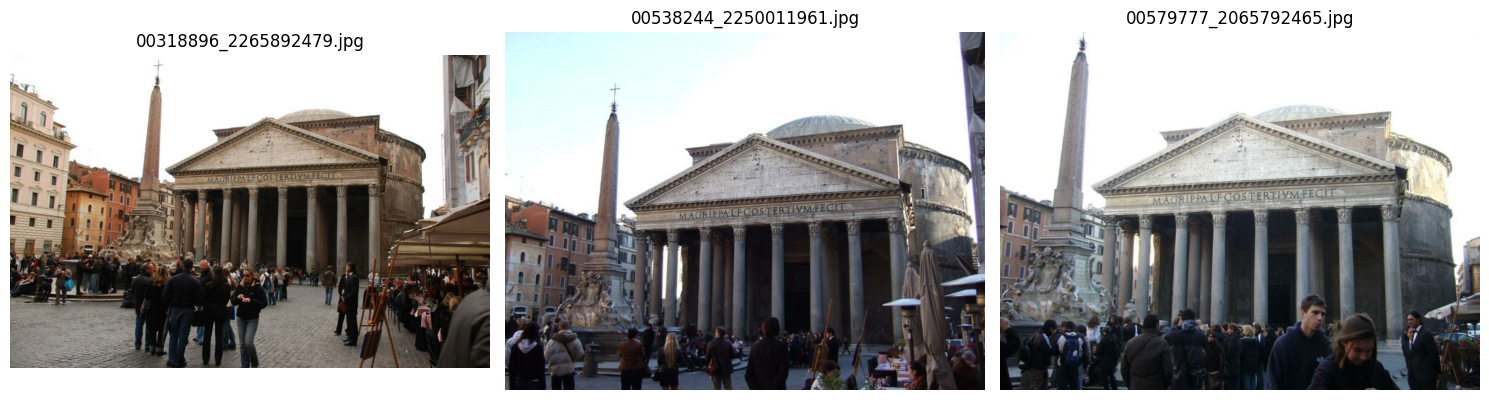

In [4]:
images_folder = "./pantheon_exterior/dense/images"

image_files = [f for f in os.listdir(images_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
images = [Image.open(os.path.join(images_folder, image_files[i])) for i in range(3)]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, img, title in zip(axes, images, image_files[:3]):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(title)

plt.tight_layout()
plt.show()

#### Pre-processing

If you go through the images in the dataset you will notice images with varying dimensions, angles, brightness levels etc. For us to effectively use our dataset, we first need to pre-process our images. Pre-processing ensures that the images are prepared consistently for feature detection, matching, and camera pose estimation.

Some helper functions that might be useful.

In [5]:
def get_img_paths(folder_pth):
    """Returns a list containing filenames of all jpg files in folder_pth"""
    jpg_files = []

    for filename in os.listdir(folder_pth):
        if filename.lower().endswith(".jpg"):
            # uncomment the line below if you want to include the entire path in the filename
            filename = os.path.join(folder_pth, filename)
            jpg_files.append(filename)

    return jpg_files


def load_images(folder_pth):
    """Loads all images in folder_path"""
    images = []
    for filename in os.listdir(folder_pth):
        if filename.lower().endswith(".jpg"):
            img = cv2.imread(os.path.join(folder_pth, filename))
            images.append(img)

    return images


def resize_image(img, size=(800, 600)):
    """Resizes image to a specified size."""
    return cv2.resize(img, size)


def convert_to_grayscale(img):
    """Converts an image to grayscale."""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# you can add other functions here as well.

Now, load the images from the dataset folder, apply the pre-processing steps, and display few of the pre-processed images to verify. I have included a few types of pre-processing methods above, but you can use any other method as well that you believe might be helpful. Give a two-liner explaination for your pre-processing choices.

**Ans:**

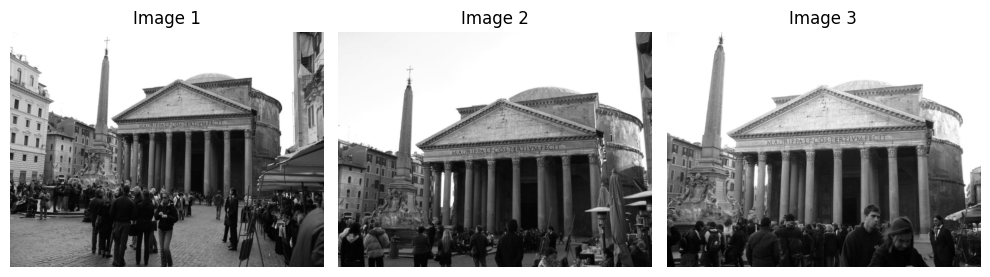

In [6]:
image_paths = get_img_paths(images_folder)
images = load_images(images_folder)

preprocessed_images = []
for img in images:
    resized = resize_image(img, size=(800, 600))  
    grayscale = convert_to_grayscale(resized)   
    preprocessed_images.append(grayscale)
    
plt.figure(figsize=(10, 5))
for i, img in enumerate(preprocessed_images[:3]):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"Image {i+1}")
plt.tight_layout()
plt.show()


### Feature Detection

The goal is to identify distinct and robust points in the images that can be matched across different views. These feature points are the key to establishing correspondences between images.

There are several feature detection algorithms such as SIFT, SURF, or ORB available in the cv2 library. When using any of the algorithms, be sure to check the format of the image that it accepts.

Using any feature detection algorithm, extract the features from two images and display the images with the features higlighted on them. Here is an example:

<img src="assets/feature_detection.png" alt="My Image" width="800"/>

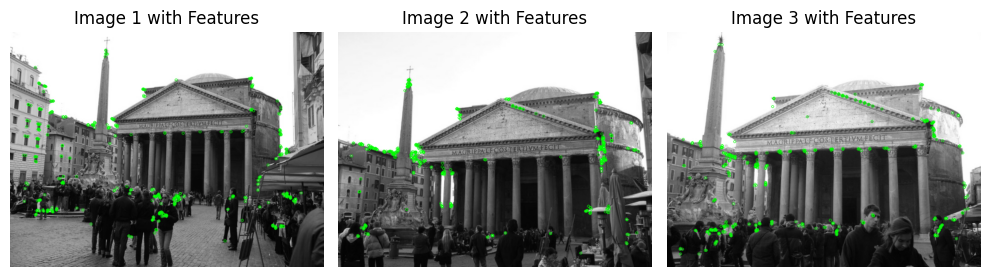

In [7]:
def detect_features(image, detector):
    """Detect and draw features on the image."""
    keypoints, descriptors = detector.detectAndCompute(image, None)
    feature_image = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0), flags=0)
    return feature_image, keypoints, descriptors

orb = cv2.ORB_create()
feature_detected_images = []
for img in preprocessed_images[:3]: 
    feature_img, keypoints, descriptors = detect_features(img, orb)
    feature_detected_images.append(feature_img)

plt.figure(figsize=(10, 5))
for i, img in enumerate(feature_detected_images):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"Image {i+1} with Features")
plt.tight_layout()
plt.show()


### Feature Matching

Feature matching is a crucial step in 3D reconstruction because it helps find corresponding points between different images. Once you've detected the keypoints and descriptors using a feature detector, the next step is to match these descriptors across pairs of images.


Use the keypoints and descriptors extracted above for the two images and match the features across the two images. You can use this as a reference image:

<img src="assets/feature_matching.png" alt="My Image" width="800"/>

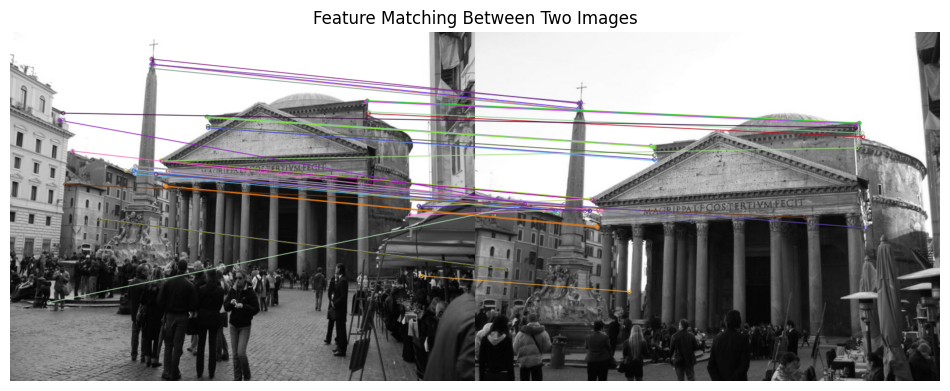

In [8]:
def match_features(img1, img2, keypoints1, descriptors1, keypoints2, descriptors2):
    """Matches features between two sets of descriptors."""
   
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)  
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)
    matched_image = cv2.drawMatches(
        img1, keypoints1, img2, keypoints2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    return matched_image, matches

keypoints1, descriptors1 = orb.detectAndCompute(preprocessed_images[0], None)
keypoints2, descriptors2 = orb.detectAndCompute(preprocessed_images[1], None)
matched_image, matches = match_features(preprocessed_images[0], preprocessed_images[1], keypoints1, descriptors1, keypoints2, descriptors2)


plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Feature Matching Between Two Images")
plt.show()


### Camera Pose Estimation

Camera pose estimation involves determining the relative position and orientation (i.e., rotation and translation) of the camera between two views. This is typically done by estimating the essential matrix or fundamental matrix between two sets of matched keypoints, and then decomposing these matrices to recover the camera pose.

So essentially:
1. Find the **fundamental matrix (F)** using the matched keypoints.
2. Decompose the **essential matrix (E)** into the rotation and translation components.
3. Use epipolar geometry to verify or refine the solution.

You can use the lecture slides as reference for computing these. 

Calculate the fundemental and essential matrices. Use these to recover the translation and rotation matrices.

In [17]:
for camera_id in id:
    camera = cameras[camera_id]
    print(f"Camera ID: {camera_id}")
    print(f"Model ID: {camera['model_id']}")
    print(f"Width: {camera['width']}")
    print(f"Height: {camera['height']}")
    print(f"Parameters: {camera['params']}")

Camera ID: 1
Model ID: 1
Width: 1070
Height: 698
Parameters: (798.1634521484375, 798.1634521484375, 535.0, 349.0)
Camera ID: 3
Model ID: 1
Width: 1036
Height: 772
Parameters: (1082.4217529296875, 1082.4217529296875, 518.0, 386.0)


In [ ]:
f_x_1 = 798.1634521484375
f_y_1 = 798.1634521484375
c_x_1 = 535.0
c_y_1 = 349.0

K_1 = np.array([[f_x_1, 0, c_x_1],
                [0, f_y_1, c_y_1],
                [0, 0, 1]])

print("Camera 1 Intrinsic Matrix (K):")
print(K_1)

f_x_3 = 1082.4217529296875
f_y_3 = 1082.4217529296875
c_x_3 = 518.0
c_y_3 = 386.0

K_3 = np.array([[f_x_3, 0, c_x_3],
                [0, f_y_3, c_y_3],
                [0, 0, 1]])

print("Camera 3 Intrinsic Matrix (K):")
print(K_3)


In [19]:
F = np.array([[-2.71511226e-07, -1.22696087e-05, 5.15832527e-03],
              [ 1.37457820e-05, 1.10813284e-06, -5.36621610e-03],
              [-7.18603896e-03, 3.79718809e-03, 1.00000000e+00]])

E = K_3.T @ F @ K_1

U, S, Vt = np.linalg.svd(E)
W = np.array([[0, -1, 0],
              [1, 0, 0],
              [0, 0, 1]])

R1 = U @ W @ Vt
R2 = U @ W.T @ Vt
t = U[:, 2]  #

print("Essential Matrix E:")
print(E)
print("\nRotation Matrix (R1):")
print(R1)
print("\nRotation Matrix (R2):")
print(R2)
print("\nTranslation Vector (t):")
print(t)


Essential Matrix E:
[[ -0.23457198 -10.60032209   0.79122143]
 [ 11.87566125   0.95737079   2.57022737]
 [ -1.61293662  -1.70067076  -0.22410498]]

Rotation Matrix (R1):
[[-0.99689839 -0.03665486 -0.06964206]
 [ 0.03988756 -0.9981627  -0.04560937]
 [ 0.0678423   0.04824576 -0.99652886]]

Rotation Matrix (R2):
[[ 0.93376194  0.05919955  0.35296467]
 [ 0.01663585  0.97797939 -0.20803743]
 [ 0.3575079  -0.2001293  -0.91221509]]

Translation Vector (t):
[-0.14557316  0.13032552  0.98072612]


### Linear Triangulation

Linear triangulation involves determining the 3D coordinates of a point in space based on its projections in two or more images taken from different viewpoints. Given two camera poses and the corresponding 2D feature points in both images, linear triangulation allows you to estimate the 3D coordinates of the points in the scene.

Compute the 3D coordinates of the matched feature points by solving the system of equations derived from the camera projection equations above.

In [13]:
pts1 = []
pts2 = []

for match in matches:

    img1_idx = match.queryIdx
    img2_idx = match.trainIdx
    (x1, y1) = keypoints1[img1_idx].pt
    (x2, y2) = keypoints2[img2_idx].pt
    pts1.append((x1, y1))
    pts2.append((x2, y2))

pts1 = np.array(pts1, dtype=np.float32)
pts2 = np.array(pts2, dtype=np.float32)

print("Matched points from Image 1:\n", pts1)
print("Matched points from Image 2:\n", pts2)


Matched points from Image 1:
 [[338.68802  145.15201 ]
 [338.40002  145.20001 ]
 [243.36002   46.08    ]
 [243.        55.      ]
 [340.07043  145.15202 ]
 [248.        56.      ]
 [613.44006  117.50401 ]
 [241.92001   61.920002]
 [340.89993  146.81091 ]
 [340.40228  146.31326 ]
 [613.7857   118.19521 ]
 [259.2      220.32    ]
 [614.4      117.600006]
 [261.27365  221.46053 ]
 [261.27365  221.87523 ]
 [152.       321.      ]
 [343.38824  164.22916 ]
 [271.22696  238.87878 ]
 [273.02402  238.46402 ]
 [612.1269   119.43939 ]
 [214.9909   229.92084 ]
 [340.40228  164.22916 ]
 [244.8       55.2     ]
 [209.43362  236.39043 ]
 [209.01894  236.39046 ]
 [152.40001  321.6     ]
 [210.81602  236.73602 ]
 [617.1035   136.85764 ]
 [214.8      243.6     ]
 [216.48389  231.41382 ]
 [616.32     139.68001 ]
 [540.46326  253.80872 ]
 [688.       314.      ]
 [703.       299.      ]
 [211.68001  237.6     ]
 [267.84     264.96002 ]
 [259.2      221.18402 ]
 [340.40228  161.24318 ]
 [198.72     237.6  

In [24]:
P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
P2_1 = np.hstack((R1, t.reshape(-1, 1)))
P2_2 = np.hstack((R2, t.reshape(-1, 1))) 

def linear_triangulation(P1, P2, pt1, pt2):

    pt1_homogeneous = np.array([pt1[0], pt1[1], 1])
    pt2_homogeneous = np.array([pt2[0], pt2[1], 1])
    A = np.zeros((4, 4))
    A[0] = pt1_homogeneous[0] * P1[2] - P1[0]
    A[1] = pt1_homogeneous[1] * P1[2] - P1[1]
    A[2] = pt2_homogeneous[0] * P2[2] - P2[0]
    A[3] = pt2_homogeneous[1] * P2[2] - P2[1]
    
    _, _, Vt = np.linalg.svd(A)
    X = Vt.T[:, -1]
    X = X / X[3]
    
    return X

X_3d_points = []

for i in range(len(pts1)):
    pt1 = pts1[i]
    pt2 = pts2[i]
    X_1 = linear_triangulation(P1, P2_1, pt1, pt2)
    X_2 = linear_triangulation(P1, P2_2, pt1, pt2)
    X_3d_points.append(X_1[:3])



Visualise the 3D points obtained above. The results will probably not make any sense atm since we are only using two images, but this will help us in Task 2.

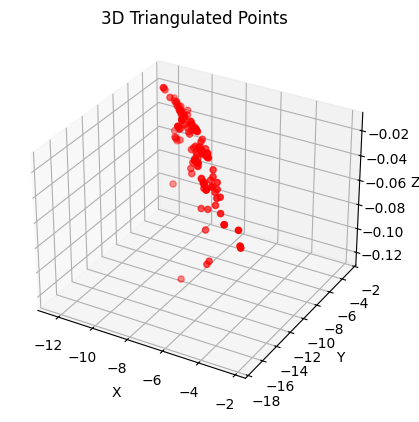

In [25]:
X_3d_points = np.array(X_3d_points)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3d_points[:, 0], X_3d_points[:, 1], X_3d_points[:, 2], c='r', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Triangulated Points')

plt.show()